https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/<br>
https://github.com/experiencor/keras-yolo3

# Object Detection With YOLOv3

The keras-yolo3 project provides a lot of capability for using YOLOv3 models, including object detection, transfer learning, and training new models from scratch.

In this section, we will use a pre-trained model to perform object detection on an unseen photograph. This capability is available in a single Python file in the repository called “yolo3_one_file_to_detect_them_all.py” that has about 435 lines. This script is, in fact, a program that will use pre-trained weights to prepare a model and use that model to perform object detection and output a model. It also depends upon OpenCV.

Instead of using this program directly, we will reuse elements from this program and develop our own scripts to first prepare and save a Keras YOLOv3 model, and then load the model to make a prediction for a new photograph.

<img src="https://i.imgur.com/Ab6GMbP.png" width="100%">

# Number of Bounding Box

YOLOv1 predicts 98 boxes (7x7 grid cells, 2 boxes per cell @448x448)<br><br>
YOLOv2 predicts 845 boxes (13x13 grid cells, 5 anchor boxes @416x416)<br><br>
YOLOv3 predicts 10,647 boxes (@416x416)<br>
For an image of size 416 x 416, YOLO predicts ((52 x 52) + (26 x 26) + (13 x 13)) x 3 = 10647 bounding boxes<br>
YOLOv3 predicts more than 10x the number of boxes predicted by YOLOv2

### YOLO v1 architechture

<img src='https://i.imgur.com/BSjws2S.png' width='100%'>

YOLO v1's input shape is converted from (448, 448) to (7, 7) by using 4 MaxPool, and some ConvLayers with 2-stride.

### YOLO v2 architecture

<img src='https://i.imgur.com/Or47LPk.png' width='100%'>

YOLO v2's input shape is converted from (416, 416) to (13, 13) by using just 5 MaxPool.

<img src="https://i.imgur.com/qFUxCM7.png">

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
cd gdrive/My Drive/Project/YOLO v3

/content/gdrive/My Drive/Project/YOLO v3


In [ ]:
!git clone https://github.com/experiencor/keras-yolo3.git

Cloning into 'keras-yolo3'...
remote: Enumerating objects: 220, done.
remote: Total 220 (delta 0), reused 0 (delta 0), pack-reused 220
Receiving objects: 100% (220/220), 91.26 KiB | 2.47 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [ ]:
cd keras-yolo3

/content/gdrive/My Drive/Project/YOLO v3/keras-yolo3


In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2020-05-13 14:56:12--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   434KB/s    in 9m 39s  

2020-05-13 15:05:52 (419 KB/s) - ‘yolov3.weights’ saved [248007048/248007048]



# Create and Save Model

The first step is to download the pre-trained model weights.

These were trained using the DarkNet code base on the MSCOCO dataset. Download the model weights and place them into your current working directory with the filename “yolov3.weights.” It is a large file and may take a moment to download depending on the speed of your internet connection.

Next, we need to define a Keras model that has the right number and type of layers to match the downloaded model weights. The model architecture is called a “DarkNet” and was originally loosely based on the VGG-16 model.

The “yolo3_one_file_to_detect_them_all.py” script provides the make_yolov3_model() function to create the model for us, and the helper function _conv_block() that is used to create blocks of layers. These two functions can be copied directly from the script.<br>
<br>
We can now define the Keras model for YOLOv3.

In [ ]:
# define the model

model = make_yolov3_model()

Next, we need to load the model weights. The model weights are stored in whatever format that was used by DarkNet. Rather than trying to decode the file manually, we can use the WeightReader class provided in the script.

To use the WeightReader, it is instantiated with the path to our weights file (e.g. ‘yolov3.weights‘). This will parse the file and load the model weights into memory in a format that we can set into our Keras model.

In [ ]:
# load the model weights

weight_reader = WeightReader('yolov3.weights')

We can then call the load_weights() function of the WeightReader instance, passing in our defined Keras model to set the weights into the layers.

In [ ]:
# set the model weights into the model

weight_reader.load_weights(model)

That’s it; we now have a YOLOv3 model for use.<br>
<br>
We can save this model to a Keras compatible .h5 model file ready for later use.

In [ ]:
# save the model to file

model.save('model.h5')

We can tie all of this together; the complete code example including functions copied directly from the “yolo3_one_file_to_detect_them_all.py” script is listed below.

In [ ]:
# create a YOLOv3 Keras model and save it to file
# based on https://github.com/experiencor/keras-yolo3
# There is no Maxpooling2D...
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model


def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    for conv in convs:
        # The third layer from the back is the target of the skip connection.
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        # ZeroPadding2D
        # If tuple of 2 tuples of 2 ints: interpreted as ((top_pad, bottom_pad), (left_pad, right_pad))
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x)  # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'],
                    conv['kernel'],
                    strides=conv['stride'],
                    padding='valid' if conv['stride'] > 1 else 'same',   # peculiar padding as darknet prefer left and top
                    name='conv_' + str(conv['layer_idx']),
                    use_bias=False if conv['bnorm'] else True)(x)        # BN's character
        # BatchNormalization
        # epsilon: Small float added to variance to avoid dividing by zero.
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        # LeakyReLU
        # alpha: float  = 0. Negative slope coefficient.
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
    return add([skip_connection, x]) if skip else x


def make_yolov3_model():
	input_image = Input(shape=(None, None, 3))
	# Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)              # layer_idx: 85
	x = concatenate([x, skip_61])       # layer_idx: 86
	# Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)              # layer_idx: 97
	x = concatenate([x, skip_36])       # layer_idx: 98
	# Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model = Model(input_image, [yolo_82, yolo_94, yolo_106])
	return model


class WeightReader:
	def __init__(self, weight_file):
		with open(weight_file, 'rb') as w_f:
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)
			transpose = (major > 1000) or (minor > 1000)
			binary = w_f.read()
		self.offset = 0
		self.all_weights = np.frombuffer(binary, dtype='float32')

	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]

	def load_weights(self, model):
		for i in range(106):
			try:
				conv_layer = model.get_layer('conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('bnorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					beta  = self.read_bytes(size) # bias
					gamma = self.read_bytes(size) # scale
					mean  = self.read_bytes(size) # mean
					var   = self.read_bytes(size) # variance
					weights = norm_layer.set_weights([gamma, beta, mean, var])
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel, bias])
				else:
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel])
			except ValueError:
				print("no convolution #" + str(i))

	def reset(self):
		self.offset = 0


# define the model
model = make_yolov3_model()
# load the model weights
weight_reader = WeightReader('yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model)
# If I want to do transfer learning, I have to additional works in this step. After doing that works, save the model to file.
# save the model to file
model.save('model.h5')

Using TensorFlow backend.


loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

Running the example may take a little less than one minute to execute on modern hardware.

As the weight file is loaded, you will see debug information reported about what was loaded, output by the WeightReader class.

At the end of the run, the model.h5 file is saved in your current working directory with approximately the same size as the original weight file (237MB), but ready to be loaded and used directly as a Keras model.

tf.keras.layers.ZeroPadding2D(
    padding=(1, 1), data_format=None, **kwargs
)<br><br>
If tuple of 2 tuples of 2 ints: interpreted as ((top_pad, bottom_pad), (left_pad, right_pad))

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, None, None, 3 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, None, None, 3 0           bnorm_0[0][0]                    
____________________________________________________________________________________________

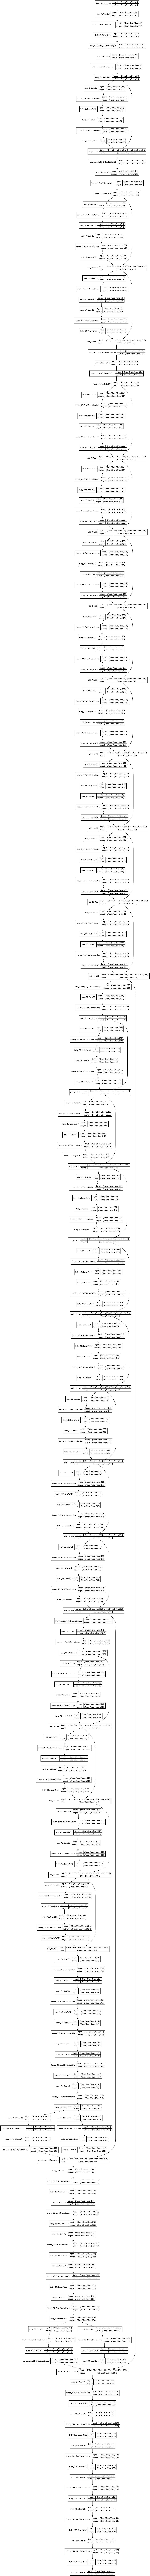

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Make a Prediction

We need a new photo for object detection, ideally with objects that we know that the model knows about from the MSCOCO dataset.

We will use a photograph of three zebras taken by Boegh on safari, and released under a permissive license.

* https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/03/zebra.jpg

Download the photograph and place it in your current working directory with the filename ‘zebra.jpg‘.

Making a prediction is straightforward, although interpreting the prediction requires some work.

The first step is to load the Keras model. This might be the slowest part of making a prediction.

In [ ]:
# load yolov3 model

model = load_model('model.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


<img src="https://i.imgur.com/hGcb8h7.png" width="100%">

Next, we need to load our new photograph and prepare it as suitable input to the model. The model expects inputs to be color images with the square shape of 416×416 pixels.

We can use the load_img() Keras function to load the image and the target_size argument to resize the image after loading. We can also use the img_to_array() function to convert the loaded PIL image object into a NumPy array, and then rescale the pixel values from 0-255 to 0-1 32-bit floating point values.

In [ ]:
# load the image with the required size
image = load_img('zebra.jpg', target_size=(416, 416))
# convert to numpy array
image = img_to_array(image)
# scale pixel values to [0, 1]
image = image.astype('float32')
image /= 255.0

We will want to show the original photo again later, which means we will need to scale the bounding boxes of all detected objects from the square shape back to the original shape. As such, we can load the image and retrieve the original shape.

In [ ]:
# load the image to get its shape
image = load_img('zebra.jpg')
width, height = image.size

We can tie all of this together into a convenience function named load_image_pixels() that takes the filename and target size and returns the scaled pixel data ready to provide as input to the Keras model, as well as the original width and height of the image.

In [ ]:
# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

We can then call this function to load our photo of zebras.

In [ ]:
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = 'zebra.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

We can now feed the photo into the Keras model and make a prediction.

In [ ]:
# 255 = (1 objectness score + 4 box coordinates + 80 class scores) x 3 bbox
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


That’s it, at least for making a prediction. The complete example is listed below.

In [ ]:
# load yolov3 model and perform object detection
# based on https://github.com/experiencor/keras-yolo3
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)   # image.shape = (1, 416, 416, 3)
    return image, width, height

# load yolov3 model
model = load_model('model.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = 'zebra.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


Running the example returns a list of three NumPy arrays, the shape of which is displayed as output.

These arrays predict both the bounding boxes and class labels but are encoded. They must be interpreted.

# Make a Prediction and Interpret Result

The output of the model is, in fact, encoded candidate bounding boxes from three different grid sizes, and the boxes are defined the context of anchor boxes, carefully chosen based on an analysis of the size of objects in the MSCOCO dataset.

The script provided by experiencor provides a function called decode_netout() that will take each one of the NumPy arrays, one at a time, and decode the candidate bounding boxes and class predictions. Further, any bounding boxes that don’t confidently describe an object (e.g. all class probabilities are below a threshold) are ignored. We will use a probability of 60% or 0.6. The function returns a list of BoundBox instances that define the corners of each bounding box in the context of the input image shape and class probabilities.

In [ ]:
# define the anchors
# anchor boxes chosen based on an analysis of the size of objects in the MSCOCO dataset
# On the COCO dataset the 9 clusters were:
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

Next, the bounding boxes can be stretched back into the shape of the original image. This is helpful as it means that later we can plot the original image and draw the bounding boxes, hopefully detecting real objects.

The experiencor script provides the correct_yolo_boxes() function to perform this translation of bounding box coordinates, taking the list of bounding boxes, the original shape of our loaded photograph, and the shape of the input to the network as arguments. The coordinates of the bounding boxes are updated directly.

In [ ]:
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

The model has predicted a lot of candidate bounding boxes, and most of the boxes will be referring to the same objects. The list of bounding boxes can be filtered and those boxes that overlap and refer to the same object can be merged. We can define the amount of overlap as a configuration parameter, in this case, 50% or 0.5. This filtering of bounding box regions is generally referred to as non-maximal suppression and is a required post-processing step.

The experiencor script provides this via the do_nms() function that takes the list of bounding boxes and a threshold parameter. Rather than purging the overlapping boxes, their predicted probability for their overlapping class is cleared. This allows the boxes to remain and be used if they also detect another object type.

In [ ]:
# suppress non-maximal boxes
do_nms(boxes, 0.5)

This will leave us with the same number of boxes, but only very few of interest. We can retrieve just those boxes that strongly predict the presence of an object: that is are more than 60% confident. This can be achieved by enumerating over all boxes and checking the class prediction values. We can then look up the corresponding class label for the box and add it to the list. Each box must be considered for each class label, just in case the same box strongly predicts more than one object.

We can develop a get_boxes() function that does this and takes the list of boxes, known labels, and our classification threshold as arguments and returns parallel lists of boxes, labels, and scores.

In [ ]:
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores

We can call this function with our list of boxes.

We also need a list of strings containing the class labels known to the model in the correct order used during training, specifically those class labels from the MSCOCO dataset. Thankfully, this is provided in the experiencor script.

In [ ]:
# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

Now that we have those few boxes of strongly predicted objects, we can summarize them.

In [ ]:
# summarize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])

We can also plot our original photograph and draw the bounding box around each detected object. This can be achieved by retrieving the coordinates from each bounding box and creating a Rectangle object.

In [ ]:
box = v_boxes[i]
# get coordinates
y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
# calculate width and height of the box
width, height = x2 - x1, y2 - y1
# create the shape
rect = Rectangle((x1, y1), width, height, fill=False, color='white')
# draw the box
ax.add_patch(rect)

We can also draw a string with the class label and confidence.

In [ ]:
# draw text and score in top left corner
label = "%s (%.3f)" % (v_labels[i], v_scores[i])
pyplot.text(x1, y1, label, color='white')

The draw_boxes() function below implements this, taking the filename of the original photograph and the parallel lists of bounding boxes, labels and scores, and creates a plot showing all detected objects.

In [ ]:
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()

We can then call this function to plot our final result.

In [ ]:
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

We now have all of the elements required to make a prediction using the YOLOv3 model, interpret the results, and plot them for review.

The full code listing, including the original and modified functions taken from the experiencor script, are listed below for completeness.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
zebra 94.91056799888611
zebra 99.86329674720764
zebra 96.87086343765259


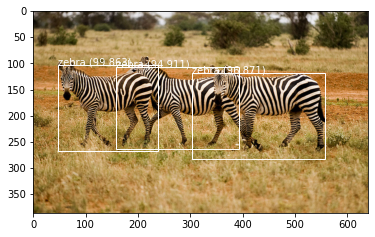

In [ ]:
# load yolov3 model and perform object detection
# based on https://github.com/experiencor/keras-yolo3
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1

	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)

		return self.label

	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]

		return self.score

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	# decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
	# very important!: Meaning for each index is [tx, ty, tw, th, p0, p1, p2, ..., p85]
	# i=0: netout=(13, 13, 255) <=> anchors=[116,90, 156,198, 373,326]
	# i=1: netout=(26, 26, 255) <=> anchors=[30,61, 62,45, 59,119]
	# i=2: netout=(52, 52, 255) <=> anchors=[10,13, 16,30, 33,23]
	# obj_thresh = 0.6, net_h = 416, net_w = 416
	grid_h, grid_w = netout.shape[:2]	# (13, 13), (26, 26), (52, 52)
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))	# i=0: (13,13,3,85)
	nb_class = netout.shape[-1] - 5							# 80 = 85 - 5
	boxes = []

	# YOLO v3 now performs multilabel classification for objects detected
	# in images
	# Softmaxing classes rests on the assumption that classes are mutually
	# exclusive.
	# However, when we have classes like Person and Women in a dataset,
	# then the above assumption fails. This is the reason why the authors
	# of YOLO have refrained from softmaxing the classes. Instead, each
	# class score is predicted using logistic regression and a threshold is
	# used to predict multiple labels for an object

	# if test's shape is (13, 13, 3, 85), test[...,:2].shape is (13, 13, 3, 2)
	netout[..., :2]  = _sigmoid(netout[..., :2])	# (13, 13, 3, 2) => tx, ty
	netout[..., 4:]  = _sigmoid(netout[..., 4:])	# (13, 13, 3, 81) => p0, p1, p2, ..., p80
	# arr(:, np.newaxis, :) => indexing으로 길이가 1인 새로운 축을 추가하기
	# I think it is no use to do this, because we have a broadcasting method.
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh

	for i in range(grid_h*grid_w):							# i=0: grid_h=13, grid_w=13
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]	# i=0: netout.shape = (13, 13, 3, 85)
			# amazing!: test_array.all() == 0 or 1(if all elements have a value)
			# although objectness.all() is scalar, it works the same.
			if(objectness.all() <= obj_thresh): continue	# if objectness's value is 0, it continues.
			# first 4 elements are x, y, w, and h
			# This part is about bounding box regresssion.
			# It is very difficult for me, so I'm not able to understand it well.
			# You are able to refer to the picture below.
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	# I don't know why this work is necessary.
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a					# x1, x2 = box1.xmin, box1.xmax
	x3, x4 = interval_b					# x3, x4 = box2.xmin, box2.xmax
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3

def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union

def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])		# descending order
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)						# image.shape = (width, height, C)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)	# image.shape = (W, H, C)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)					# image.shape = (1, W, H, C)
	return image, width, height

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()

# load yolov3 model
model = load_model('model.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = 'zebra.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))	# image.shape = (1, W, H, C)
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])		# [(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
# define the anchors
# anchor boxes chosen based on an analysis of the size of objects in the MSCOCO dataset
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):			# len(yhat) == 3
	# decode the output of the network
	# (13, 13, 255) <=> [116,90, 156,198, 373,326]
	# (26, 26, 255) <=> [30,61, 62,45, 59,119]
	# (52, 52, 255) <=> [10,13, 16,30, 33,23]
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)
# define the labels
# Authors still train on full images with no hard negative mining or any of that stuff.
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

Running the example again prints the shape of the raw output from the model.

This is followed by a summary of the objects detected by the model and their confidence. We can see that the model has detected three zebra, all above 90% likelihood.

A plot of the photograph is created and the three bounding boxes are plotted. We can see that the model has indeed successfully detected the three zebra in the photograph.

# Bounding Box Regression

<img src="https://i.imgur.com/Bsza1Xm.png">

# Summary

In this tutorial, you discovered how to develop a YOLOv3 model for object detection on new photographs.

Specifically, you learned:

* YOLO-based Convolutional Neural Network family of models for object detection and the most recent variation called YOLOv3.
* The best-of-breed open source library implementation of the YOLOv3 for the Keras deep learning library.
* How to use a pre-trained YOLOv3 to perform object localization and detection on new photographs.

# Reference

How to Perform Object Detection With YOLOv3 in Keras
* https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/

keras-yolo3
* https://github.com/experiencor/keras-yolo3

What’s new in YOLO v3?
* https://towardsdatascience.com/yolo-v3-object-detection-53fb7d3bfe6b

tf.keras.layers.ZeroPadding2D
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/ZeroPadding2D?hl=ko

Bounding Box Regression
* https://www.youtube.com/watch?v=HMgcvgRrDcA